In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from pathlib import Path
from datetime import datetime
import urllib3
# from numba import jit

import yfinance as yahooFinance
import investpy

import kit as kit

C:\Users\jaime.aguilera\Desktop\Desktop\04-python\09-investing-projects\Investing-projects\kit.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
C:\Users\jaime.aguilera\Desktop\Desktop\04-python\09-investing-projects\Investing-projects\kit.py:47: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
C:\Users\jaime.aguilera\Desktop\Desktop\04-python\09-investing-projects\Investing-projects\kit.py:50: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


In [2]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

pd.options.mode.chained_assignment = None  # default='warn'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#### Function definition

In [3]:
def get_asset_yahoo(asset):
  
    ind = yahooFinance.Ticker(asset).history(period="max")
    ind = ind["Close"]
    ind.name = asset.split('.', 1)[0]
    
    return ind

def get_asset_investing(asset, asset_name, date_beg='01/01/2009'):
    
    search = investpy.search_quotes(text=asset, n_results=1)
    ind = search.retrieve_historical_data(from_date=date_beg, to_date=datetime.today().strftime('%d/%m/%Y'))["Close"]
    ind.name = asset_name
    
    return ind

def get_asset_local(asset):

    ind = pd.read_csv(asset, sep=";", decimal=',').set_index('Date')
    ind.index = pd.to_datetime(ind.index, format="%d/%m/%Y")
    
    return ind

def get_asset(list_yahoo=None, list_investing=None, list_local=None):
    
    if list_yahoo == None:       
        prices_yahoo = None  
    else:    
        prices_yahoo = pd.concat((get_asset_yahoo(f) for f in list_yahoo), axis=1)
        
    if list_investing == None:      
        prices_investing = None      
    else:     
        prices_investing = pd.concat((get_asset_investing(*f) for f in list_investing), axis=1)
        
    if list_local == None:        
        prices_local = None      
    else:    
        prices_local = pd.concat((get_asset_local(f) for f in list_local), axis=1)
    
    prices = pd.concat([prices_yahoo, prices_investing, prices_local], axis=1)  
    
    return prices

In [4]:
def frame_returns(prices):
    
    df = prices.pct_change()
    
    return df

In [5]:
def create_trades():
    
    trades = pd.DataFrame(columns=["Date", "Ticker", "Amount"])
    
    return trades

def join_trades(df, trades):
    
    trades["Date"] = pd.to_datetime(trades["Date"], format="%d-%m-%Y")
    trades = trades.set_index(["Ticker","Date"]).rename(columns={'Amount':'Trades'})
    
    df_stack = df.stack().reset_index().rename(columns={'level_1':'Ticker', 0: 'Returns'}).set_index(["Ticker", "Date"])
    
    df_join = df_stack.join(trades).unstack(level=0)
    df_join.loc[:,"Trades"].fillna(0, inplace = True)
    
    return df_join

In [6]:
# @jit(nopython=True)
def roll(a,b):
    res = np.empty(b.shape)
    res[0] = b[0]
    for i in range(1, res.shape[0]):
        res[i] = res[i-1] * (1 + a[i]) + b[i]
    return res

def compute_wealth(df):
    
    df_wealth = df

    for i in df_wealth["Trades"].columns:

        df_wealth[("Total", i)] = roll(*np.nan_to_num(df_wealth[[("Returns", i), ("Trades", i)]].values.T))
        
    return df_wealth

In [7]:
def portfolio_rets_weights(df):
    
    weights = df["Total"].div(df["Total"].sum(axis=1), axis=0)  
    
    r = df["Returns"]  
    
    r['PORT'] =  (weights * r).sum(axis=1) 
    
    return r, weights

In [8]:
def rolling_vol(r, time_period = 90, col_drop_plot = None):
    
    roll_vol = r.drop(columns = col_drop_plot).rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)
    
    roll_vol.plot(figsize=(16,5), title = '{}-periods rolling volatility'.format(time_period))
    
    return roll_vol

def portfolio_report(df, weights = None, date_beg = None, date_end = None, col_drop_plot = None, time_period = 90):
    
    if date_end == None:
        
        date_end = df.index[-1]
        
    if col_drop_plot == None:
    
        (1+df.dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
        
        df.dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
    
    else:
        
        (1+df.drop(columns = col_drop_plot).dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
        
        df.drop(columns = col_drop_plot).dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
        
    stats = kit.summary_stats(df.dropna()[date_beg:date_end], riskfree_rate=0)
    
#     roll_vol = rolling_vol(df.dropna()[date_beg:date_end], time_period = time_period, col_drop_plot = col_drop_plot)
    
    if weights is not None:
    
        weights.dropna().plot(figsize=(16,5), title = 'Portfolio weights')
    
    return stats

#### Parameters initialization

In [14]:
# Yahoo: Introduce ticker as in Yahoo Finance (.DE stands for XETRA)
list_yahoo = ["EUNL.DE", "XDEM.F", "4GLD.DE", "WCOA.MI", "ZPRS.DE", "EUNZ.F", "BTC-EUR", "BRYN.DE"]

# Investing: First element is Investing text search, second is desired name for the asset
list_investing = [['Fundsmith Equity T Acc EUR', 'FSMI'], ['MFS Meridian Prudent Wealth I1 EUR', 'PRUD']]

# Local: Write your own path. csv must contain only two columns, 'Date' with date format "%d/%m/%Y" and 'asset name' (e.g FSMI) with asset prices
list_local = glob.glob(r'C:\Users\aguil\OneDrive\Escritorio\Escritorio\Python Projects\6. Investing projects\data\Assets' + "/*.csv")

#### Execution

Wall time: 8.82 s


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.008144,0.124714,-0.465483,4.443887,0.013663,0.019693,0.065298,-0.091344
BRYN,0.458058,0.170678,0.002470,4.174840,0.015829,0.022113,2.683758,-0.075175
BTC-EUR,0.229963,0.780942,0.100454,4.768927,0.063020,0.089672,0.294469,-0.523755
EUNL,0.252648,0.141648,-0.539924,6.000280,0.014390,0.020994,1.783636,-0.098529
EUNZ,0.101882,0.115837,-0.348288,4.280091,0.012080,0.015895,0.879534,-0.054096
FSMI,0.190272,0.116211,0.045358,3.306433,0.011215,0.014628,1.637296,-0.109538
PRUD,0.098846,0.062589,-0.329271,4.162004,0.006451,0.009274,1.579297,-0.034023
WCOA,0.404571,0.137155,-1.314425,8.403442,0.014729,0.021675,2.949732,-0.080140
XDEM,0.141176,0.184695,-0.482136,3.623324,0.019791,0.027644,0.764372,-0.147082


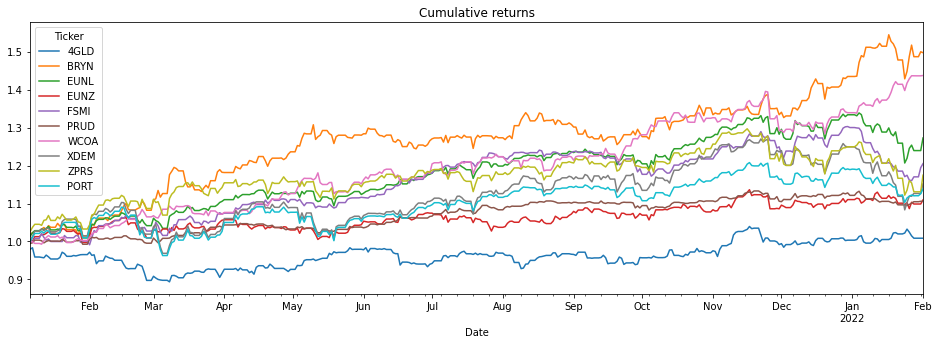

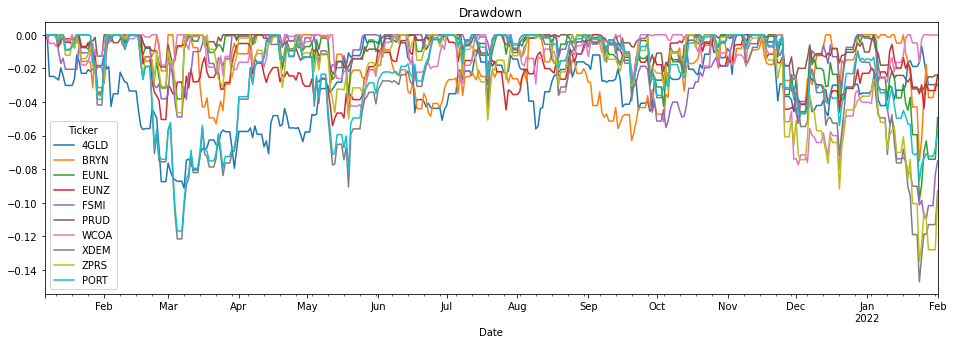

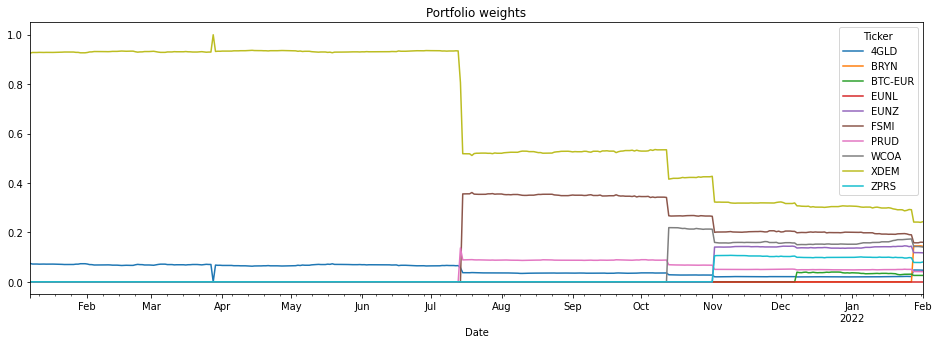

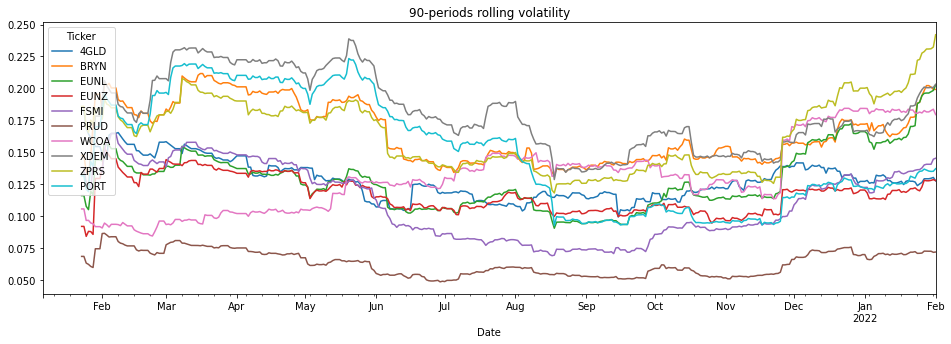

In [15]:
%%time

prices = get_asset(list_yahoo, list_investing, list_local=None)
rets = frame_returns(prices)
trades = create_trades()

trades = trades.append({"Date": "07-01-2021","Ticker":"4GLD", "Amount":300.88}, ignore_index=True)
trades = trades.append({"Date": "07-01-2021","Ticker":"XDEM", "Amount":3728.27}, ignore_index=True)
trades = trades.append({"Date": "28-03-2021","Ticker":"4GLD", "Amount":-282.40}, ignore_index=True)
trades = trades.append({"Date": "29-03-2021","Ticker":"4GLD", "Amount":273.24}, ignore_index=True)
trades = trades.append({"Date": "14-07-2021","Ticker":"PRUD", "Amount":700.00}, ignore_index=True)
trades = trades.append({"Date": "15-07-2021","Ticker":"FSMI", "Amount":2800.00}, ignore_index=True)
trades = trades.append({"Date": "13-10-2021","Ticker":"WCOA", "Amount":2240.10}, ignore_index=True)
trades = trades.append({"Date": "02-11-2021","Ticker":"ZPRS", "Amount":1494.57}, ignore_index=True)
trades = trades.append({"Date": "02-11-2021","Ticker":"EUNZ", "Amount":1991.72}, ignore_index=True)
trades = trades.append({"Date": "08-12-2021","Ticker":"BTC-EUR", "Amount":584.46}, ignore_index=True)
trades = trades.append({"Date": "28-01-2022","Ticker":"4GLD", "Amount":518.20}, ignore_index=True)
trades = trades.append({"Date": "28-01-2022","Ticker":"BRYN", "Amount":2487.15}, ignore_index=True)

rets_trades = join_trades(rets, trades)
rets_trades_wealth = compute_wealth(rets_trades)
rets_portfolio, weights_portfolio = portfolio_rets_weights(rets_trades_wealth)

stats = portfolio_report(rets_portfolio, weights = weights_portfolio, date_beg = "2021-01-06", col_drop_plot = ["BTC-EUR"])
roll_vol = rolling_vol(rets_portfolio.dropna()["2021-01-06":], time_period = 90, col_drop_plot = ["BTC-EUR"])
stats

# Other analysis

#### Test current weights on a longer period

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.100864,0.127578,-0.065356,9.402536,0.012078,0.019059,0.790601,-0.182267
BRYN,0.142341,0.213399,-0.135839,8.959221,0.020410,0.032357,0.667015,-0.287161
BTC-EUR,0.395275,0.782644,-0.102812,10.533399,0.060524,0.092956,0.505051,-0.827479
EUNL,0.133748,0.176231,-0.979410,14.546924,0.018010,0.028415,0.758934,-0.336322
EUNZ,0.054067,0.152739,-0.966596,9.712265,0.016883,0.024123,0.353984,-0.267947
FSMI,0.148552,0.152486,-0.759583,8.708995,0.016291,0.024201,0.974199,-0.269354
PRUD,0.094729,0.072788,-0.066444,4.870416,0.007237,0.010198,1.301447,-0.073030
WCOA,0.091710,0.115934,-0.638708,8.358174,0.012647,0.017827,0.791053,-0.218176
XDEM,0.149581,0.199004,-0.408997,7.676813,0.020276,0.031393,0.751650,-0.317425


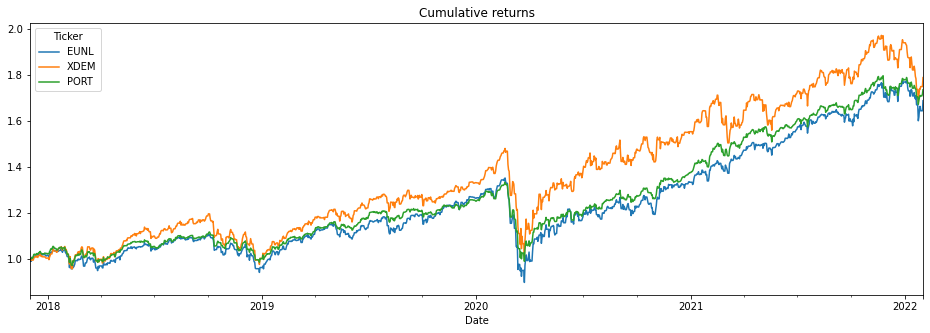

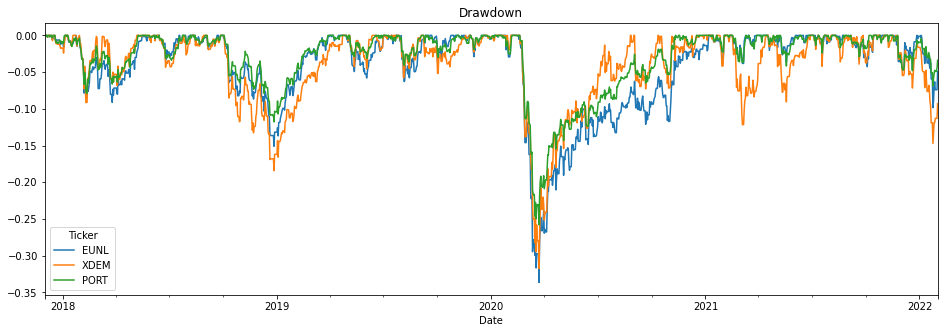

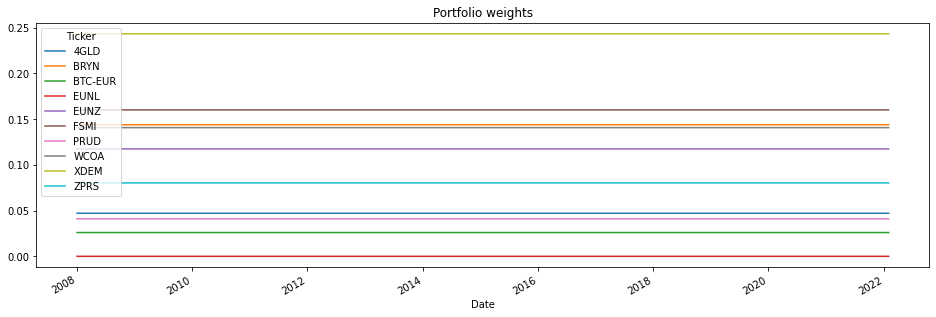

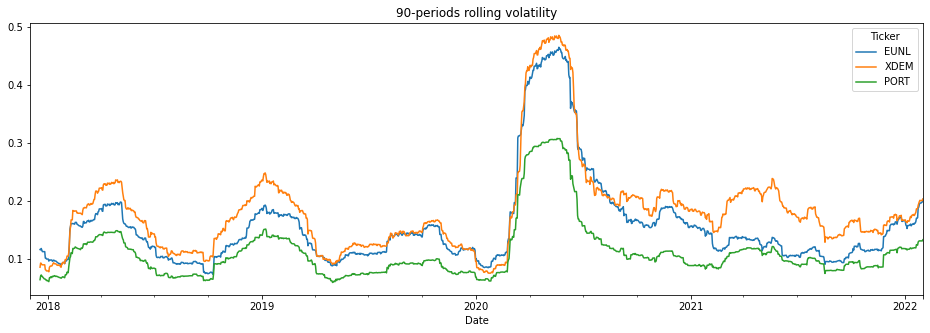

In [25]:
weights = weights_portfolio.copy()
weights.iloc[:-1,:]=np.nan
weights=weights.fillna(method="bfill")

df_portfolio = rets_trades_wealth["Returns"]  
df_portfolio['PORT'] = (weights * df_portfolio).sum(axis=1) 

col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]

stats_long = portfolio_report(df_portfolio, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(df_portfolio.dropna()["2017-12":], col_drop_plot = col_drop_plot)
stats_long

#### Monthly/weekly/business days report

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.099410,0.115176,-0.851568,5.916889,0.026862,0.040254,0.863113,-0.173035
BRYN,0.153178,0.206715,-0.617476,5.876513,0.047268,0.072263,0.741012,-0.254979
BTC-EUR,0.426367,0.795721,-0.081692,3.750273,0.168350,0.234592,0.535825,-0.823520
EUNL,0.136026,0.170905,-1.660899,13.319851,0.041013,0.059771,0.795916,-0.292886
EUNZ,0.049095,0.139913,-1.115980,7.779771,0.034416,0.049974,0.350897,-0.243539
FSMI,0.148774,0.151300,-1.725806,10.684666,0.037252,0.056307,0.983308,-0.221121
PRUD,0.094303,0.066287,-0.856889,5.910174,0.014825,0.020515,1.422644,-0.056389
WCOA,0.089055,0.107126,-0.638623,5.258832,0.024438,0.032404,0.831313,-0.189856
XDEM,0.151180,0.193388,-1.229192,8.515235,0.046373,0.067404,0.781743,-0.273991


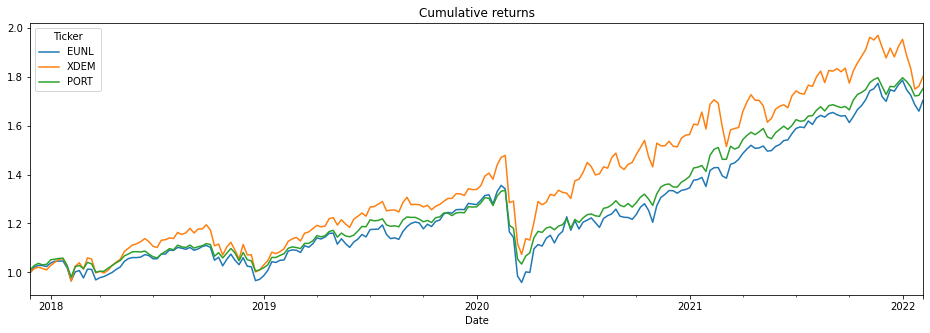

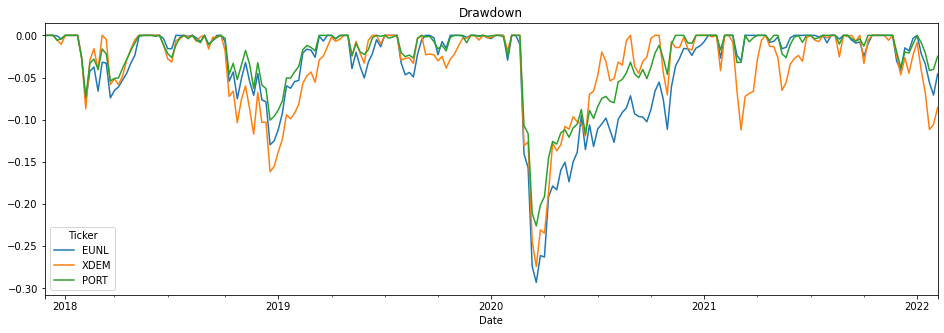

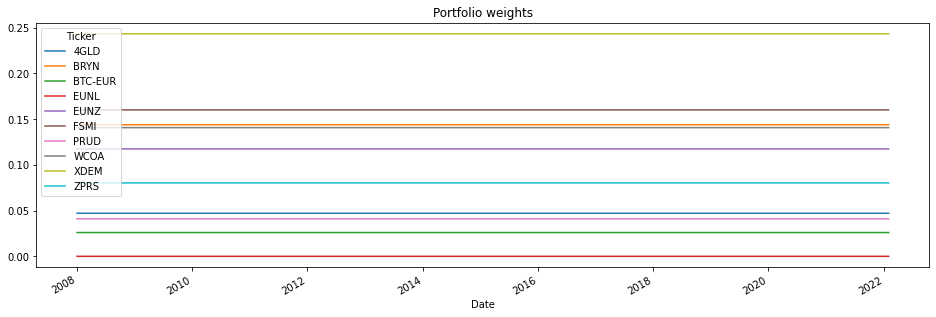

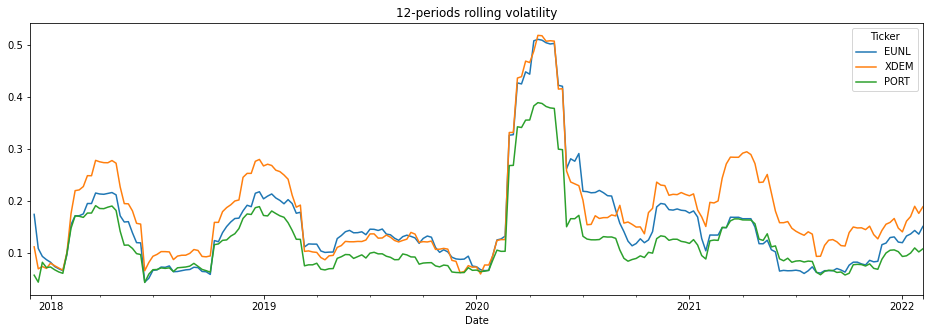

In [26]:
df_portfolio_w = df_portfolio.resample('W').apply(kit.compound)
df_portfolio_m = df_portfolio.resample('M').apply(kit.compound)
df_portfolio_b = df_portfolio.resample('B').apply(kit.compound)

stats_w = portfolio_report(df_portfolio_w, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(df_portfolio_w.dropna()["2017-12":], time_period = 12, col_drop_plot = col_drop_plot)
stats_w

#### Plot density function of returns

(-0.04, 0.04)

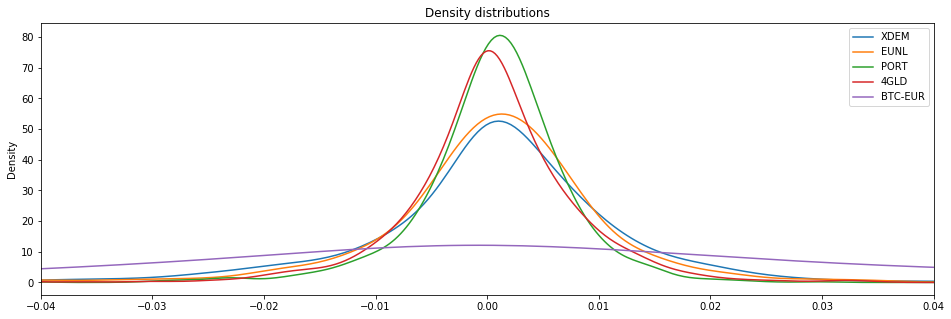

In [60]:
r = df_portfolio_b.loc["2017-12":, ["XDEM", "EUNL", "PORT", "4GLD", "BTC-EUR"]]
x_lim = 0.04

# r.hist(bins=30, figsize=(15,10), label='x')

r.plot.kde(figsize=(16,5), title = 'Density distributions')
plt.xlim([-x_lim, +x_lim])

#### Get rolling correlation of rest of assets against a particular asset

,4GLD,BTC-EUR,WCOA,PRUD,EUNZ,FSMI,XDEM,PORT,ZPRS,EUNL
0,-0.018522,0.175583,0.450048,0.684403,0.686326,0.715056,0.76495,0.882312,0.903893,1.0


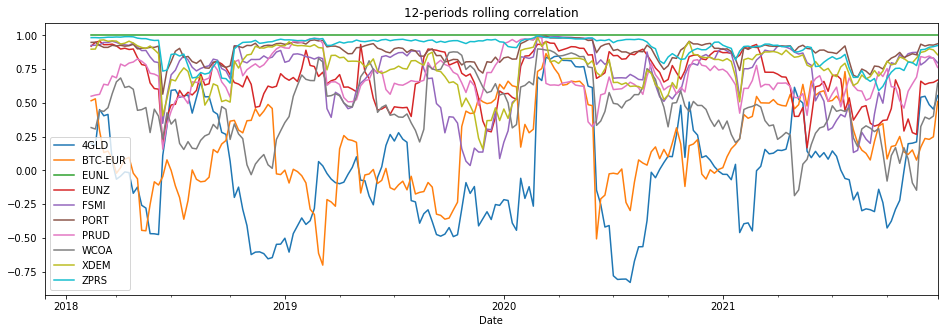

In [61]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

r = df_portfolio_w.loc["2017-12":]

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r, time_period = 12, col = 'EUNL')

#### Study inclusion of alternative asset in the portfolio

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.0,0.138123,0.123747,-1.150235,16.802194,0.010421,0.017306,1.116177,-0.257945
0.1,0.133817,0.127079,-1.132132,17.448385,0.010605,0.017820,1.053023,-0.266450
0.2,0.129434,0.130965,-1.100583,17.946555,0.010829,0.018390,0.988306,-0.274881
0.3,0.124973,0.135357,-1.058777,18.293469,0.011091,0.019011,0.923285,-0.283239
0.4,0.120436,0.140206,-1.009828,18.498091,0.011392,0.019682,0.858991,-0.291523
0.5,0.115824,0.145468,-0.956503,18.577211,0.011729,0.020419,0.796216,-0.299735
0.6,0.111138,0.151099,-0.901094,18.551416,0.012100,0.021163,0.735532,-0.307874
0.7,0.106380,0.157060,-0.845384,18.441996,0.012502,0.021936,0.677321,-0.315941
0.8,0.101550,0.163314,-0.790685,18.268921,0.012933,0.022733,0.621807,-0.323936
0.9,0.096649,0.169829,-0.737906,18.049738,0.013390,0.023568,0.569096,-0.331860


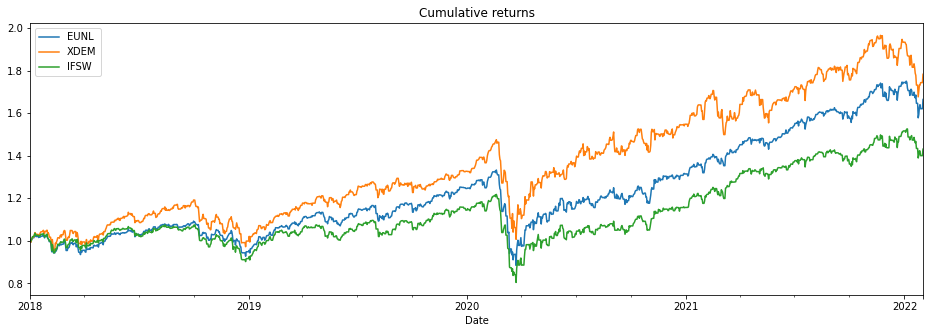

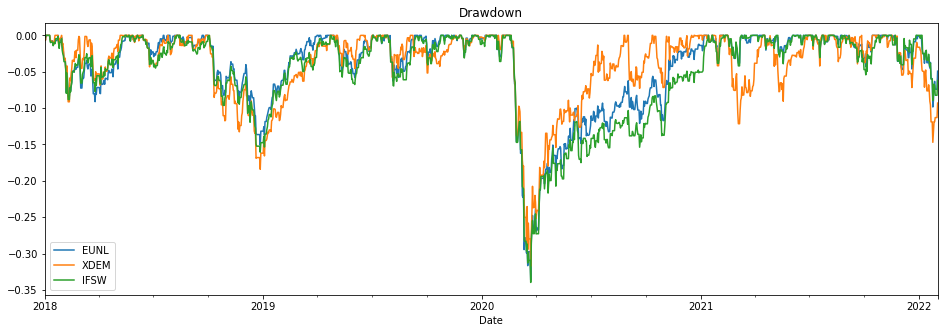

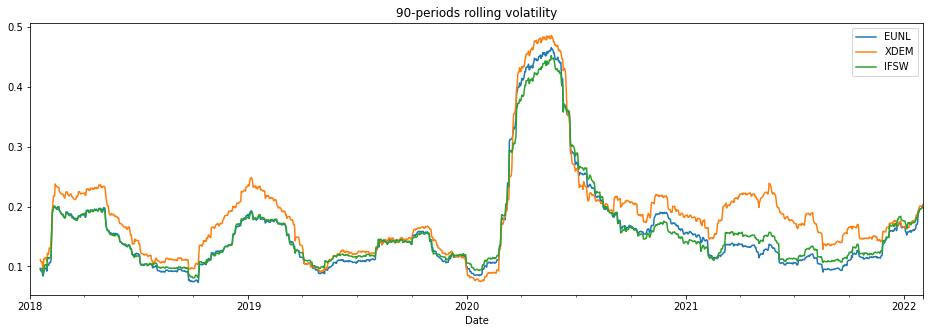

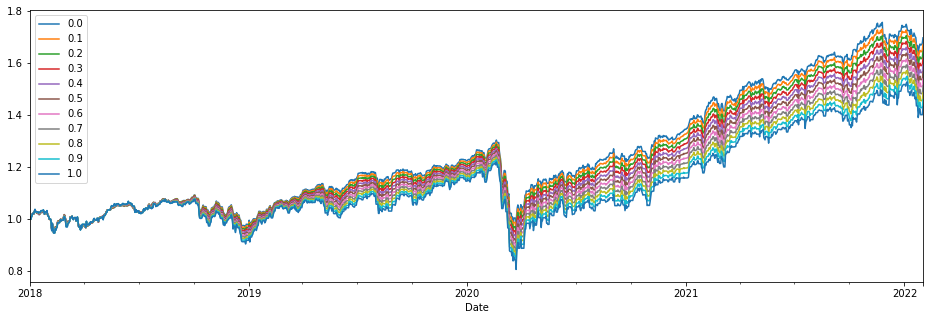

In [20]:
alt_name = 'IFSW'

# Get asset returns
alt_ticker = ['IFSW.MI']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2016-09-28":]

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r.loc[:,alt_name] = r.loc[:,alt_name].fillna(0)
r = r.dropna()

# Optional: Include in portfolio report
col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]
portfolio_report(r, date_beg = "2018", col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(r["2018":], col_drop_plot = col_drop_plot)

# Optional: Get correlation matrix
# r['2018':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
weight_series = weights_portfolio.iloc[-1]
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,1,11)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2018":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2018":], riskfree_rate = 0)